Preprocess Cut Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided data file
file_path = '../Train.csv'
data = pd.read_csv(file_path)

# Convert 'date_time' to datetime format for proper plotting
data['date_time'] = pd.to_datetime(data['date_time'])

# Displaying the first few rows of the dataset to understand its structure
data.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


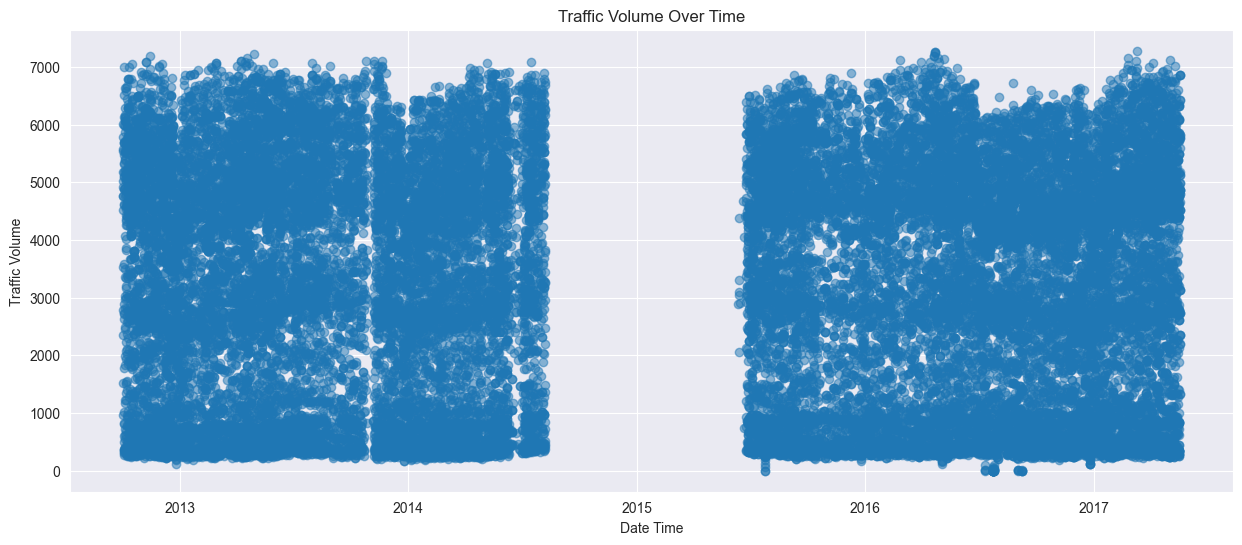

In [2]:
# Creating scatter plot
plt.figure(figsize=(15, 6))

# Scatter plot for 'traffic_volume' against 'date_time'
plt.scatter(data['date_time'], data['traffic_volume'], alpha=0.5)

# Labeling the plot
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time')

# Display the plot
plt.show()

In [3]:
# Convert 'date_time' to datetime format and sort the data
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.sort_values(by='date_time')

# Calculate the difference in time between consecutive entries to find the gap
data['time_diff'] = data['date_time'].diff()

# Identify the largest time gap which would indicate the start of 'C' and end of 'A'
max_gap = data['time_diff'].max()
max_gap_row = data[data['time_diff'] == max_gap]

# Extract the end of 'A' and start of 'C'
end_of_A = max_gap_row['date_time'].iloc[0] - max_gap
start_of_C = max_gap_row['date_time'].iloc[0]


In [4]:
end_of_A, start_of_C

(Timestamp('2014-08-08 01:00:00'), Timestamp('2015-06-11 20:00:00'))

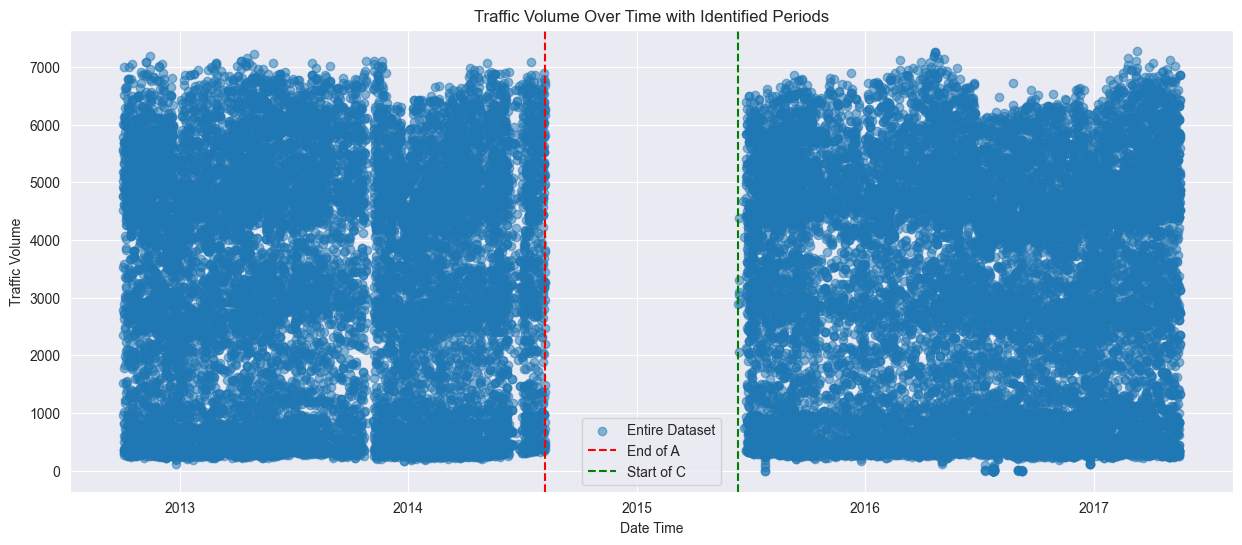

In [5]:
# Creating scatter plots with the correctly identified periods
plt.figure(figsize=(15, 6))

# Scatter plot for the entire dataset
plt.scatter(data['date_time'], data['traffic_volume'], alpha=0.5, label='Entire Dataset')

# Adding the lines for end of 'A' and start of 'C'
plt.axvline(x=end_of_A, color='red', linestyle='--', label='End of A')
plt.axvline(x=start_of_C, color='green', linestyle='--', label='Start of C')

# Labeling the plot
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time with Identified Periods')
plt.legend()

# Display the plot
plt.show()

plt.show()


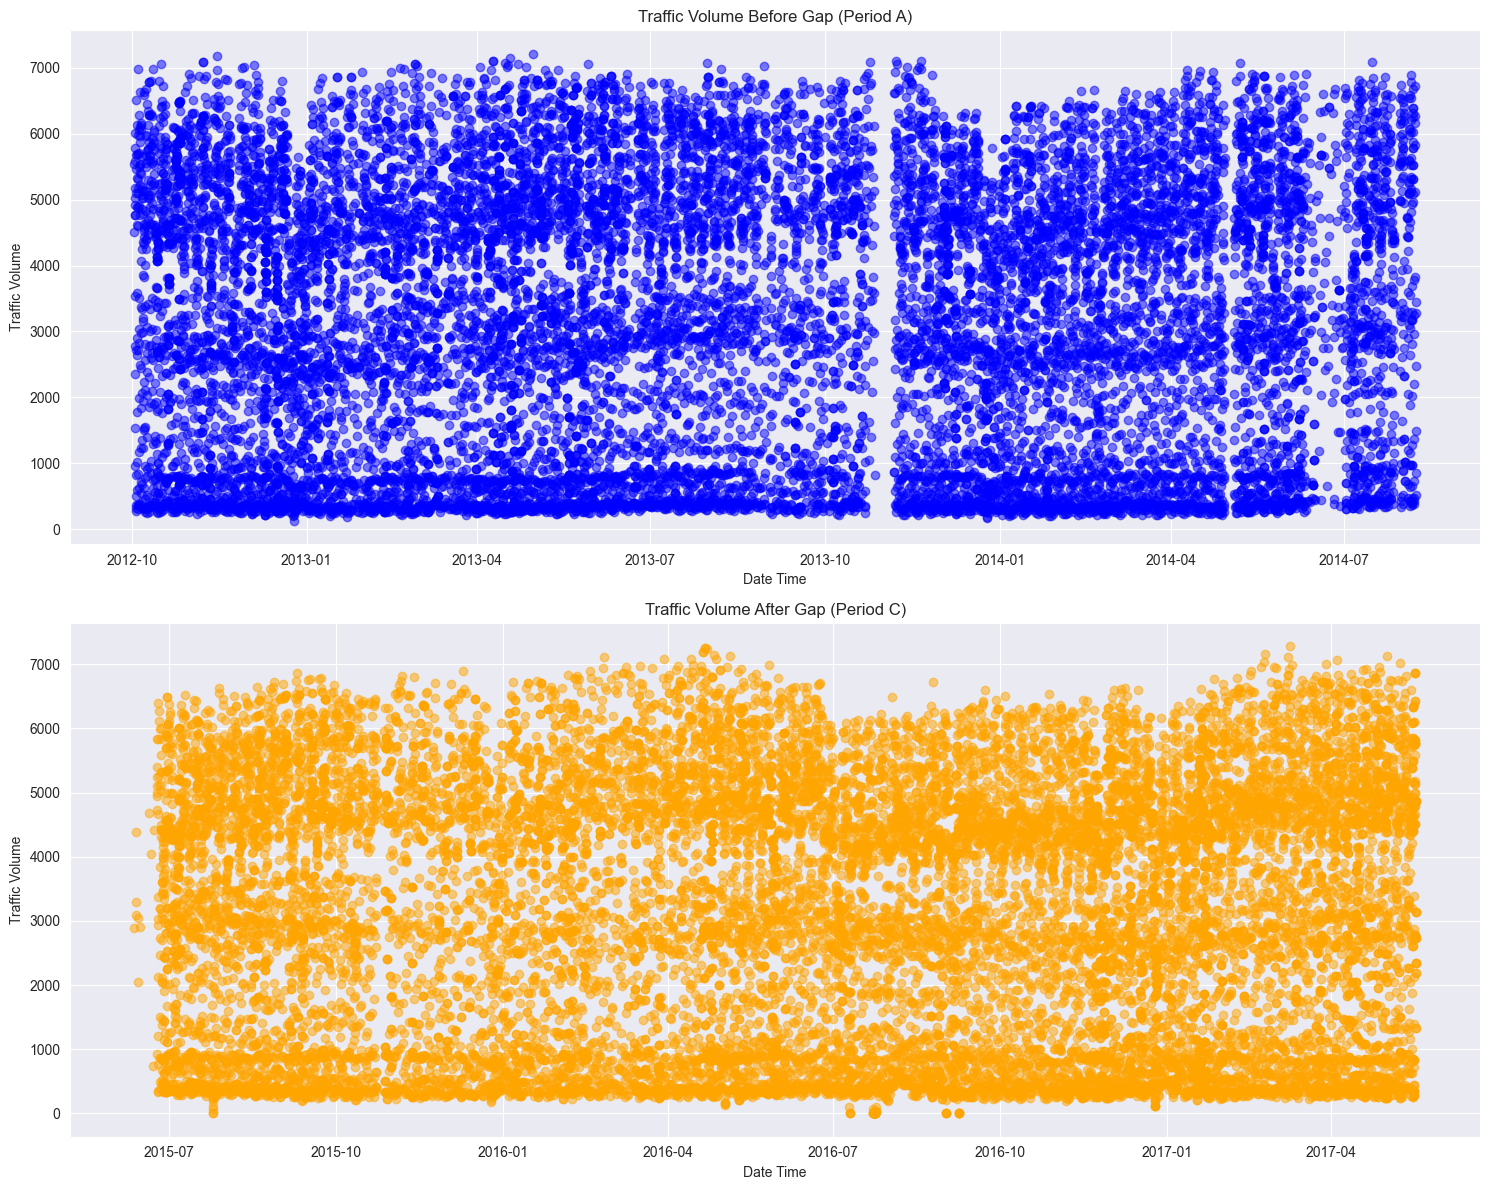

In [6]:
# Filter data for period A and C
data_A = data[data['date_time'] <= end_of_A]
data_C = data[data['date_time'] >= start_of_C]

# Creating scatter plots for periods A and C
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Plot for period A
ax[0].scatter(data_A['date_time'], data_A['traffic_volume'], alpha=0.5, color='blue')
ax[0].set_title('Traffic Volume Before Gap (Period A)')
ax[0].set_xlabel('Date Time')
ax[0].set_ylabel('Traffic Volume')

# Plot for period C
ax[1].scatter(data_C['date_time'], data_C['traffic_volume'], alpha=0.5, color='orange')
ax[1].set_title('Traffic Volume After Gap (Period C)')
ax[1].set_xlabel('Date Time')
ax[1].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

In [ ]:
# Load the dataset
df_raw = pd.read_csv('../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

Period A

In [ ]:
start_of_C = '2015-06-11 20:00:00'
df_period_C = df_raw[df_raw['date_time'] >= start_of_C]

In [ ]:
# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate: mean for numeric columns, mode for non-numeric columns
agg_funcs = {col: 'mean' for col in df_period_C.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})

df_aggregated = df_period_C.groupby('date_time').agg(agg_funcs).reset_index()

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=non_numeric_cols, drop_first=True)

# Add hour from the 'date_time' column
df['hour'] = df['date_time'].dt.hour

In [ ]:
# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Save 'date_time' for later use
date_time = df['date_time']

# Drop 'date_time' column before scaling
df = df.drop(columns=['date_time'])

In [ ]:
# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into train and test sets
split_index = int(len(X_scaled) * 0.9)
X_train, y_train = X_scaled[:split_index], y[:split_index]
X_test, y_test = X_scaled[split_index:], y[split_index:]

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the GridSearchCV object with the time series cross-validator
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1
)

# Fit the grid search to the scaled data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters_grid = grid_search.best_params_
print(f"Best parameters found with GridSearchCV: {best_parameters_grid}")

# Train the best model on the scaled data
best_model_grid = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model_grid, 'best_xgboost_model_gridsearch.joblib')

In [ ]:
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)
}

# Evaluate metrics on the validation set
y_val_pred_grid = best_model_grid.predict(X_test)
val_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred_grid)),
    'MSE': mean_squared_error(y_test, y_val_pred_grid),
    'MAE': mean_absolute_error(y_test, y_val_pred_grid),
    'MAPE': mape_scorer(y_test, y_val_pred_grid),
    'R2': r2_score(y_test, y_val_pred_grid)
}

# Print and compare metrics for GridSearchCV
print("\nMetrics with GridSearchCV:")
print("Training Set Metrics:")
print(train_metrics_grid)
print("\nValidation Set Metrics:")
print(val_metrics_grid)

In [ ]:
df.columns

In [ ]:
df

In [ ]:
date_time

In [ ]:
df = pd.concat([date_time, df], axis=1)

In [ ]:
df.columns

In [ ]:
# Function to update the lagged features with the new prediction
def update_lagged_features(df, new_prediction, max_lags=3):
    for i in range(max_lags-1, 0, -1):
        df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
    df['traffic_volume_lag_1'] = new_prediction

# Initialize DataFrame for dynamic forecasting
df_dynamic_forecast = X_test.copy()
df_dynamic_forecast['forecasted_traffic_volume'] = np.nan

# Number of steps to forecast
forecast_steps = 720

for i in range(forecast_steps):
    # Predict the traffic volume for the next time step
    current_prediction = best_model_grid.predict(df_dynamic_forecast.iloc[i:i+1].drop(columns=['forecasted_traffic_volume']))[0]
    df_dynamic_forecast.at[df_dynamic_forecast.index[i], 'forecasted_traffic_volume'] = current_prediction

    # Update lagged features with the new prediction for the next iteration
    if i + 1 < forecast_steps:
        update_lagged_features(df_dynamic_forecast.iloc[i + 1], current_prediction)

In [ ]:
# Initialize the DataFrame
test_date_times = df['date_time'][split_index:].reset_index(drop=True)

df_result = pd.DataFrame({
    'date_time': test_date_times,
    'actual_traffic_volume': y_test.reset_index(drop=True),
    'lag_1': np.nan,
    'lag_2': np.nan,
    'lag_3': np.nan,
    'forecasted_traffic_volume': df_dynamic_forecast['forecasted_traffic_volume'].reset_index(drop=True)
})

# Set the initial lagged values from the historical data
df_result.loc[0, 'lag_1'] = df.loc[split_index - 1, 'traffic_volume']
df_result.loc[0, 'lag_2'] = df.loc[split_index - 2, 'traffic_volume']
df_result.loc[0, 'lag_3'] = df.loc[split_index - 3, 'traffic_volume']

# Update the lagged values with the forecasted values in each step
for i in range(1, len(df_result)):
    df_result.loc[i, 'lag_1'] = df_result.loc[i - 1, 'forecasted_traffic_volume']
    df_result.loc[i, 'lag_2'] = df_result.loc[i - 1, 'lag_1']
    df_result.loc[i, 'lag_3'] = df_result.loc[i - 1, 'lag_2']

# Display the DataFrame
print(df_result.head(forecast_steps))

In [ ]:
import matplotlib.pyplot as plt

# Select the steps for plotting
df_plot = df_result.head(forecast_steps)

# Plotting the actual vs. forecasted traffic volumes
plt.figure(figsize=(15, 7))
plt.plot(df_plot['date_time'], df_plot['actual_traffic_volume'], label='Actual Traffic Volume', color='black', marker='o')
plt.plot(df_plot['date_time'], df_plot['forecasted_traffic_volume'], label='Forecasted Traffic Volume', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Forecasted Traffic Volume (First 720 Steps)')
plt.legend()

# Display the plot
plt.show()

In [ ]:
df_result.tail()

In [ ]:
df_result.dropna(inplace=True)

In [ ]:
actual_values = df_result['actual_traffic_volume']
new_forecasted_values = df_result['forecasted_traffic_volume']

# Evaluate metrics on the training set
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)  # R2 score for training set
}

# Calculate the metrics for forecasted values
forecast_metrics = {
    'RMSE': np.sqrt(mean_squared_error(actual_values, new_forecasted_values)),
    'MSE': mean_squared_error(actual_values, new_forecasted_values),
    'MAE': mean_absolute_error(actual_values, new_forecasted_values),
    'MAPE': mape_scorer(actual_values, new_forecasted_values),
    'R2': r2_score(actual_values, new_forecasted_values)  # R2 score for forecast
}

# Print the metrics
print("\nMetrics for Train Values:")
print(train_metrics_grid)
print("\nMetrics for Forecasted Values:")
print(forecast_metrics)
